# Running analog Hamiltonian simulation with local simulator

It is advised to test and debug an analog Hamiltonian simulation (AHS) program on the local simulator before submitting it to the QPU. In this notebook, we introduce several features of the local simulator that will be useful to streamline this testing process.

To begin, we import the necessary packages.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

import numpy as np
import matplotlib.pyplot as plt
import time
from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from ahs_utils import show_register, show_global_drive, show_final_avg_density, get_drive, get_avg_density
from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

In [this notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/02_Ordered_phases_in_Rydberg_systems.ipynb), we consider a chain of 9 atoms, and realized the 1D $Z_2$ phase via adiabatic evolution. Here we will consider a chain with 15 atoms with exactly the same driving field, which will realize the similar $Z_2$ phase.

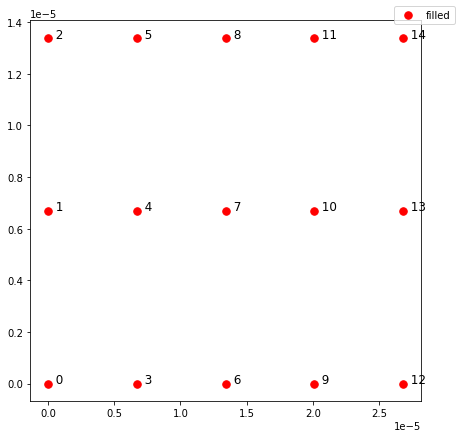

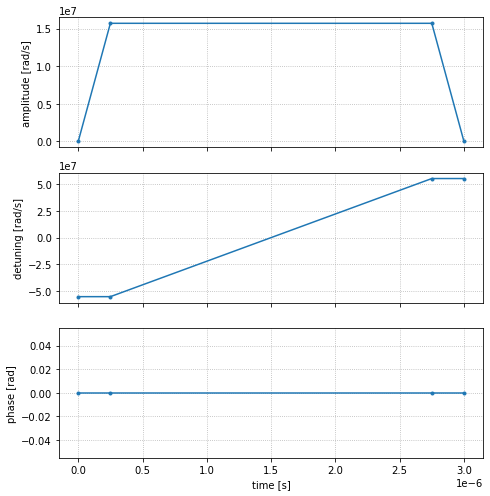

In [2]:
register = AtomArrangement()
separation = 6.7e-6  # in meters 

for k in range(5):
    for l in range(3):
        register.add((k * separation, l * separation))


time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7  # rad / s
detuning_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)    
    
    
show_register(register)
show_global_drive(drive);

The AHS program can be constructed by assembling the atomic register with the driving field.

In [3]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

We can then run the program on the local simulator as usual.

In [4]:
device = LocalSimulator("braket_ahs")

In [ ]:
start_time = time.time()
result_full = device.run(ahs_program, shots=1000, progress_bar=True).result()
print(f"The elapsed time = {time.time()-start_time}")

In [ ]:
show_final_avg_density(result_full)

## Run AHS program in the blockade subspace

As we can see above, it takes a much longer time to finish the simulation because the *full* Hamiltonian is of size $2^{15}\times 2^{15}$. However, because of Rydberg blockade, we know that neighboring atoms are very unlikely to be excited to the Rydberg states simultaneously. Hence the *effective* Hamiltonian for the adiabatic evolution is much smaller then the full Hamiltonian of the system. We can take advantage of this fact by setting the parameter `blockade_radius` to the atomic separation to speed up the simulation.

In [ ]:
start_time = time.time()
result_blockade = device.run(ahs_program, shots=1000, blockade_radius=separation, progress_bar=True).result()
print(f"The elapsed time = {time.time()-start_time}")

In [ ]:
show_final_avg_density(result_blockade)

In order to quantify the difference in the final average Rydberg densities from the two simulations, we can calculate the root-mean-square difference (RMS) defined as 
\begin{align}
\text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N(\bar{n}_i^\text{full}-\bar{n}_i^\text{blockade})^2}.
\end{align}
Here $\bar{n}_i^\text{full}$ and $\bar{n}_i^\text{blockade}$ are the final Rydberg density at the $i$-th site for the simulation with full Hilbert space and truncated Hilbert space respectively.

In [ ]:
n_full = get_avg_density(result_full)
n_blockade = get_avg_density(result_blockade)

RMS = np.sqrt(np.mean((np.array(n_full)-np.array(n_blockade))**2))
print(f"The RMS for the final Rydberg densities = {RMS}")

Since the RMS is approximately zero, we are assured that the simulation with truncated Hilbert space give quantitatively the same results as the one with the full Hilbert space.

In [ ]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")